In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from pdftotextByPage import mining


<H3>문장들로 이뤄진 데이터 불러오기

In [6]:
train_data = pd.read_table('txtoutput.txt')

if (train_data.isnull().values.any() == 'True'):
    train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

train_data.columns


Index(['Chapter 2:  Operating-System '], dtype='object')

In [7]:
train_data

,Chapter 2: Operating-System
0,Structures (구조)
1,Operating System Concepts – 10th Edition
2,"Silberschatz, Galvin and Gagne ©2018"
3,Chapter 2: Operating-System Structures
4,❖ 운영체제 서비스 (Operating System Services)
...,...
950,"Silberschatz, Galvin and Gagne ©2018"
951,End of Chapter 2
952,Operating System Concepts – 10th Edition
953,"Silberschatz, Galvin and Gagne ©2018"


<h3> 열이름 지정

In [8]:
train_data.columns=['Document'] 
train_data[:5]

,Document
0,Structures (구조)
1,Operating System Concepts – 10th Edition
2,"Silberschatz, Galvin and Gagne ©2018"
3,Chapter 2: Operating-System Structures
4,❖ 운영체제 서비스 (Operating System Services)


<h3>문장에서 명사 추출

In [9]:
from konlpy.tag import Okt

nounsLine = []
nouns=[]
Okt = Okt()

for i in range (len(train_data['Document'])):
                line = train_data['Document'][i]# 한 페이지 씩 읽어 옴
                nouns = Okt.nouns(line) #한 페이지에 있는 명사들 모두 nouns에 저장 (리스트)

                if len(nouns) == 0 : 
                    nounsLine.append(' ')
                    continue #명사 없을 경우 ' ' 저장 후 pass
                line= ' '.join(map(str, nouns))
                nounsLine.append(line)
nounsLine
train_data['tokenizedDocument'] = nounsLine

<h3>결측값 제거

In [10]:
indexing = train_data[train_data['tokenizedDocument'] == ' '].index
train_data = train_data.drop(indexing)

<h2>토큰화

In [11]:
from tqdm import tqdm
from konlpy.tag import Okt

okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['tokenizedDocument']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    tokenized_data.append(tokenized_sentence)

100%|██████████| 432/432 [00:00<00:00, 4075.35it/s]


In [12]:
#토큰 화 된 전체 단어 수 확인
count = len(tokenized_data)
for i in range(len(tokenized_data)):
    count+=len(tokenized_data[i])
count

2193

<h1> Word2Vec 모델 사용 </h1>
<h6>1.size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.</h6>
<h6>2.window = 컨텍스트 윈도우 크기</h6>
<h6>3.min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)</h6>
<h6>4.workers = 학습을 위한 프로세스 수</h6>
<h6>5.sg = 0은 CBOW, 1은 Skip-gram.</h6>

In [13]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 3, min_count = 1, workers = 4, sg = 0)
model.wv.vectors.shape

(490, 100)

<h1>문장 벡터 계산

In [14]:
senVecs = [] # 문장 벡터 저장할 리스트
for i in range(len(tokenized_data)): # 데이터 길이 (문장 갯수 만큼 반복)
    senVecs.append(0) # 리스트에 0을 추가하고
    for j in range(len(tokenized_data[i])): # 각각 단어 벡터를 이용해 평균 벡터 추출, 문장 벡터 저장할 리스트에 가져옴
        senVecs[i] += (model.wv.get_vector(tokenized_data[i][j]))/len(tokenized_data[i])

<h3> senVecs에 저장된 벡터들은 배열 형태로 저장됨. 데이터 프레임에 넣기 위해 리스트 로 형변환 해주는 작업

In [15]:
#영벡터 처리 위해 만듦
blankVec = []
for i in range(100):
    blankVec.append(0)
blankVec

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [16]:
veclist = [] #리스트로 변환된 벡터들 여기에 담음
for i in range(len(senVecs)):
    if (type(senVecs[i]) == int):
        veclist.append(blankVec) #영벡터 처리
        continue
    veclist.append(list(senVecs[i]))

In [17]:
len(veclist[0]) # 차원 수와 같음

100

In [18]:
len(veclist) # 문장 수와 같음

432

<h1>dataframe에 벡터들 담을 열 생성 (100차원이므로 100개 생성)

In [19]:
dmCol = []    #차원 100개 맞춰 생성

for i in range(100):
    dmCol.append('dm%d'%(i+1)) # append로 요소 추가
 
dmCol

['dm1',
 'dm2',
 'dm3',
 'dm4',
 'dm5',
 'dm6',
 'dm7',
 'dm8',
 'dm9',
 'dm10',
 'dm11',
 'dm12',
 'dm13',
 'dm14',
 'dm15',
 'dm16',
 'dm17',
 'dm18',
 'dm19',
 'dm20',
 'dm21',
 'dm22',
 'dm23',
 'dm24',
 'dm25',
 'dm26',
 'dm27',
 'dm28',
 'dm29',
 'dm30',
 'dm31',
 'dm32',
 'dm33',
 'dm34',
 'dm35',
 'dm36',
 'dm37',
 'dm38',
 'dm39',
 'dm40',
 'dm41',
 'dm42',
 'dm43',
 'dm44',
 'dm45',
 'dm46',
 'dm47',
 'dm48',
 'dm49',
 'dm50',
 'dm51',
 'dm52',
 'dm53',
 'dm54',
 'dm55',
 'dm56',
 'dm57',
 'dm58',
 'dm59',
 'dm60',
 'dm61',
 'dm62',
 'dm63',
 'dm64',
 'dm65',
 'dm66',
 'dm67',
 'dm68',
 'dm69',
 'dm70',
 'dm71',
 'dm72',
 'dm73',
 'dm74',
 'dm75',
 'dm76',
 'dm77',
 'dm78',
 'dm79',
 'dm80',
 'dm81',
 'dm82',
 'dm83',
 'dm84',
 'dm85',
 'dm86',
 'dm87',
 'dm88',
 'dm89',
 'dm90',
 'dm91',
 'dm92',
 'dm93',
 'dm94',
 'dm95',
 'dm96',
 'dm97',
 'dm98',
 'dm99',
 'dm100']

In [20]:
df = pd.DataFrame(veclist, columns = dmCol) #dataframe으로 만듦
df

,dm1,dm2,dm3,dm4,dm5,dm6,dm7,dm8,dm9,dm10,...,dm91,dm92,dm93,dm94,dm95,dm96,dm97,dm98,dm99,dm100
0,-0.007170,0.004643,0.002010,0.007501,-0.004887,-0.005357,-0.005760,0.004217,-0.005038,0.008296,...,-0.002548,0.003782,-0.005913,-0.008675,-0.004703,0.006987,0.006614,0.009218,0.007253,0.006541
1,-0.005301,-0.000575,0.007301,-0.001753,0.006079,-0.000912,0.000076,0.008217,0.003253,-0.006080,...,0.002528,-0.001900,0.004203,-0.007843,0.000870,0.001776,0.007241,0.001635,-0.001220,0.006140
2,-0.000462,0.002014,0.002089,-0.001637,0.002416,-0.002520,-0.001925,0.005422,-0.005349,-0.003058,...,0.002268,0.002126,0.003207,-0.002082,0.000615,0.002956,0.007110,-0.002643,0.000919,-0.003627
3,-0.003864,0.001322,-0.001225,0.003596,-0.002804,-0.001827,0.004267,0.006927,-0.005205,0.001258,...,0.003992,-0.001948,0.004172,-0.001898,0.007608,-0.001013,-0.001034,-0.001420,0.000995,0.004425
4,-0.004928,0.003882,0.001339,0.001008,-0.002917,-0.000709,-0.000431,0.005966,-0.002053,0.002809,...,-0.000226,-0.001477,0.003784,-0.000260,0.006111,-0.000723,-0.001144,0.000318,0.000535,0.004782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.001695,-0.000903,-0.001228,-0.001298,-0.003413,-0.000135,0.000776,0.003685,-0.002434,-0.002524,...,0.003286,0.000609,-0.002204,-0.000332,0.000608,0.000768,-0.000225,-0.003370,-0.002443,-0.000184
428,0.000808,0.001341,-0.002324,0.001429,-0.004344,-0.003535,0.001577,0.006601,-0.007497,-0.005732,...,0.001777,0.001619,-0.003518,0.001701,0.004072,-0.004870,0.003065,-0.001153,0.000368,0.000421
429,-0.003085,-0.005854,-0.001516,-0.000774,0.000034,-0.001541,0.002491,0.006036,-0.006507,0.000318,...,0.002629,-0.000181,0.004893,0.002040,0.003498,0.005458,-0.000850,-0.006046,-0.003890,0.000568
430,-0.004916,0.007783,-0.003566,0.001967,0.002523,-0.003323,-0.003200,0.005304,-0.001907,-0.006395,...,-0.003831,0.004042,-0.002931,-0.001388,0.005606,0.002213,0.005865,-0.002161,-0.005317,0.001148


<h3> 문장과 해당 벡터를 파악할수 있도록 문장정보,벡터 한 데이터 프레임에 합치기

In [21]:
result3 = pd.concat([train_data.reset_index(drop=True),df.reset_index(drop=True)],axis=1) 
# train_Data(본 문장과 문장에서 토큰화 된 단어들 저장), df(벡터 저장) 
# reset_index(drop=True) - 병합 위해 각 데이터 프레임에서의 인덱스 초기화.
result3

,Document,tokenizedDocument,dm1,dm2,dm3,dm4,dm5,dm6,dm7,dm8,...,dm91,dm92,dm93,dm94,dm95,dm96,dm97,dm98,dm99,dm100
0,Structures (구조),구조,-0.007170,0.004643,0.002010,0.007501,-0.004887,-0.005357,-0.005760,0.004217,...,-0.002548,0.003782,-0.005913,-0.008675,-0.004703,0.006987,0.006614,0.009218,0.007253,0.006541
1,❖ 운영체제 서비스 (Operating System Services),운영체제 서비스,-0.005301,-0.000575,0.007301,-0.001753,0.006079,-0.000912,0.000076,0.008217,...,0.002528,-0.001900,0.004203,-0.007843,0.000870,0.001776,0.007241,0.001635,-0.001220,0.006140
2,❖ 운영체제 사용자 인터페이스 (User Operating System Interf...,운영체제 사용자 인터페이스,-0.000462,0.002014,0.002089,-0.001637,0.002416,-0.002520,-0.001925,0.005422,...,0.002268,0.002126,0.003207,-0.002082,0.000615,0.002956,0.007110,-0.002643,0.000919,-0.003627
3,❖ 시스템 콜 (System Calls),시스템 콜,-0.003864,0.001322,-0.001225,0.003596,-0.002804,-0.001827,0.004267,0.006927,...,0.003992,-0.001948,0.004172,-0.001898,0.007608,-0.001013,-0.001034,-0.001420,0.000995,0.004425
4,❖ 시스템 콜 유형 (Types of System Calls),시스템 콜 유형,-0.004928,0.003882,0.001339,0.001008,-0.002917,-0.000709,-0.000431,0.005966,...,-0.000226,-0.001477,0.003784,-0.000260,0.006111,-0.000723,-0.001144,0.000318,0.000535,0.004782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,부트블록(boot block)이 메모리에 로드되고 이것이 디스크에서,부트 블록 이 메모리 로드 것 디스크,0.001695,-0.000903,-0.001228,-0.001298,-0.003413,-0.000135,0.000776,0.003685,...,0.003286,0.000609,-0.002204,-0.000332,0.000608,0.000768,-0.000225,-0.003370,-0.002443,-0.000184
428,부트스트랩 로더를 메모리에 적재한다,부트스트랩 로더 메모리 적재,0.000808,0.001341,-0.002324,0.001429,-0.004344,-0.003535,0.001577,0.006601,...,0.001777,0.001619,-0.003518,0.001701,0.004072,-0.004870,0.003065,-0.001153,0.000368,0.000421
429,❖ GRUB(GRand Unified Bootloader) : Linux 시스템을 ...,시스템 위 오픈소스,-0.003085,-0.005854,-0.001516,-0.000774,0.000034,-0.001541,0.002491,0.006036,...,0.002629,-0.000181,0.004893,0.002040,0.003498,0.005458,-0.000850,-0.006046,-0.003890,0.000568
430,부트스트랩 프로그램,부트스트랩 프로그램,-0.004916,0.007783,-0.003566,0.001967,0.002523,-0.003323,-0.003200,0.005304,...,-0.003831,0.004042,-0.002931,-0.001388,0.005606,0.002213,0.005865,-0.002161,-0.005317,0.001148


In [22]:
result3.to_csv('./final.csv')

In [23]:
# 한글 폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
fontpath = 'C:/Windows/Fonts/malgun.ttf' # for Windows
font = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font)

c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  


In [24]:
import matplotlib.pyplot as plt

# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(8 ,6))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

In [25]:
# 단어벡터를 구한다.
word_vectors = model.wv
# 벡터들의 키들
vocabs = word_vectors.key_to_index.keys()
# 벡터들
word_vectors_list = [word_vectors[v] for v in vocabs]

In [26]:
# type(vocabs)
print(vocabs)

dict_keys(['시스템', '운영체제', '사용자', '프로그램', '콜', '제공', '파일', '사용', '실행', '커널', '인터페이스', '메모리', '서비스', '프로세스', '계층', '구조', '생', '다른', '정보', '명령', '구현', '명령어', '장치', '관리', '적재', '등', '전달', '를', '접근', '위', '매개변수', '모듈', '기능', '방법', '및', '것', '하드웨어', '해석기', '통신', '가지', '종료', '기법', '코드', '자원', '설정', '수행', '일반', '정책', '언어', '이', '수', '오류', '은', '효율', '각', '분리', '함', '설계', '변경', '의', '성능', '획득', '상태', '공유', '종류', '입출력', '컴퓨터', '일부', '목표', '선택', '디버깅', '위해', '메시지', '환경', '프로그래밍', '대한', '유형', '윈도우', '시간', '개발', '시작', '대부분', '구성', '속성', '반환', '향상', '시', '보장', '위치', '가능', '예', '모든', '스택', '블록', '간', '운영', '레지스터', '쉘', '할당', '덤프', '디렉토리', '때', '보호', '공간', '보안', '포함', '데', '업무', '지원', '부팅', '로더', '결정', '경우', '개', '디스크', '적', '셸', '필요', '마우스', '더', '기초', '단일', '라이브러리', '작성', '거나', '파라미터', '가상', '호출', '고급', '모드', '여러', '다수', '이식', '마이크로커널', '대해', '입력', '다중', '집합', '정상', '비정상', '요청', '삭제', '쓰기', '부분', '연결', '테이블', '하위', '숫자', '개발자', '제거', '로', '기록', '내용', '함수', '알', '제대로', '간의', '컴파일러', '최', '용어', '별로', 

In [27]:
# 시각화를 위해 차원을 줄여보자.
# PCA로 차원을 축소해본다.
# 결과1 : 단어간 유사도를 확인
from sklearn.decomposition import PCA

# 주성분의 개수
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


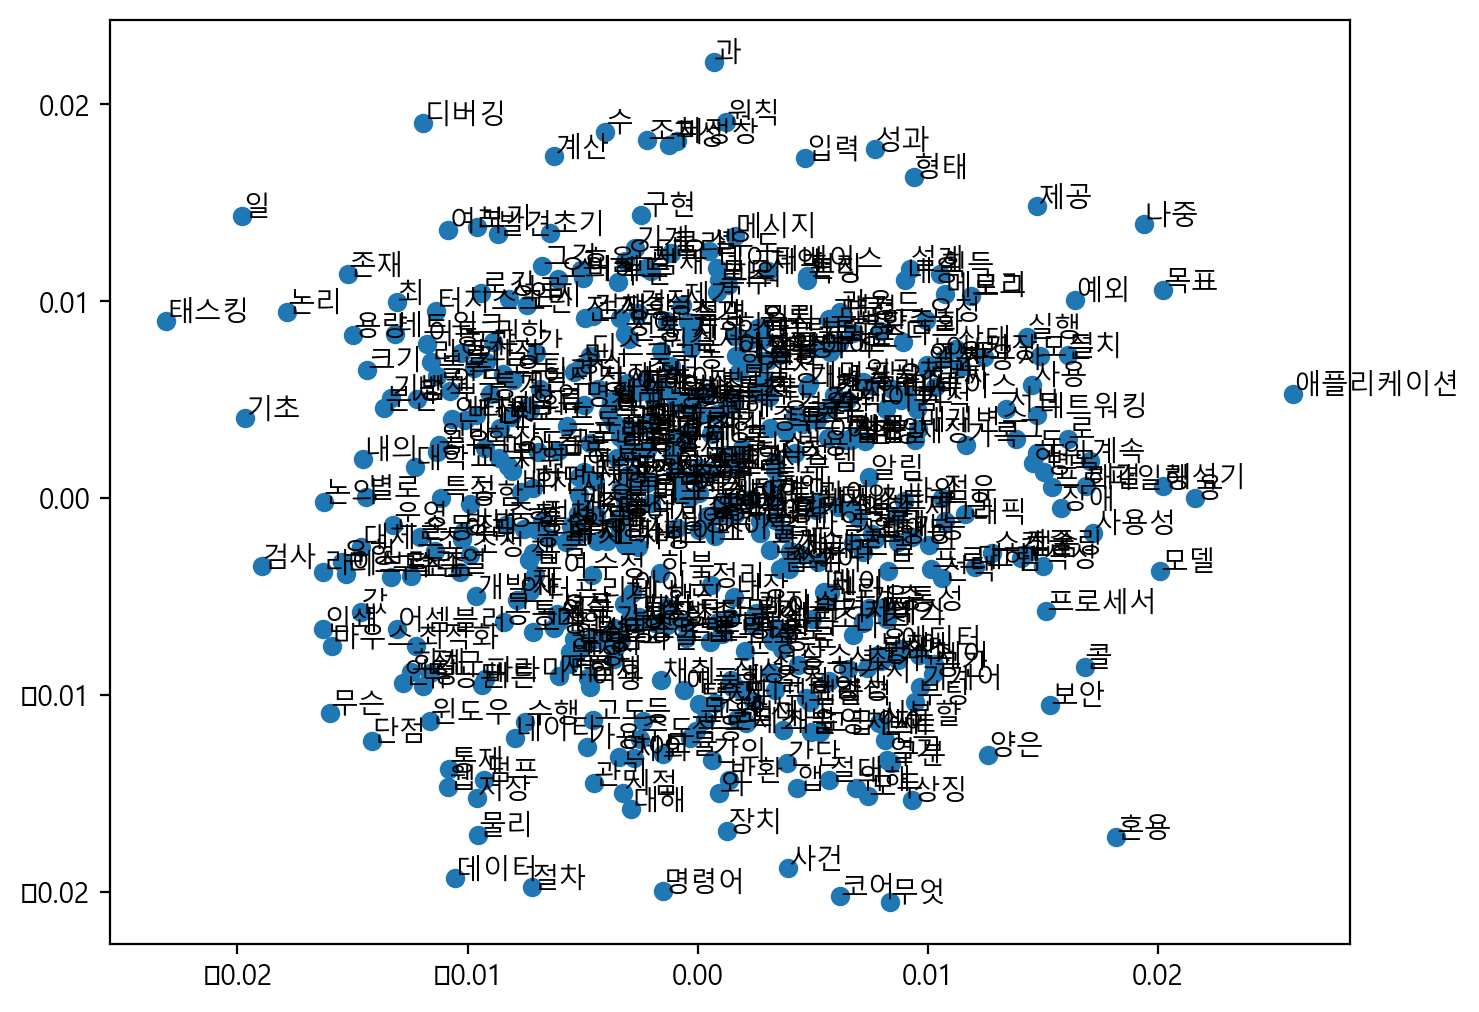

In [28]:
# https://ebbnflow.tistory.com/153
plot_2d_graph(vocabs, xs, ys)

c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


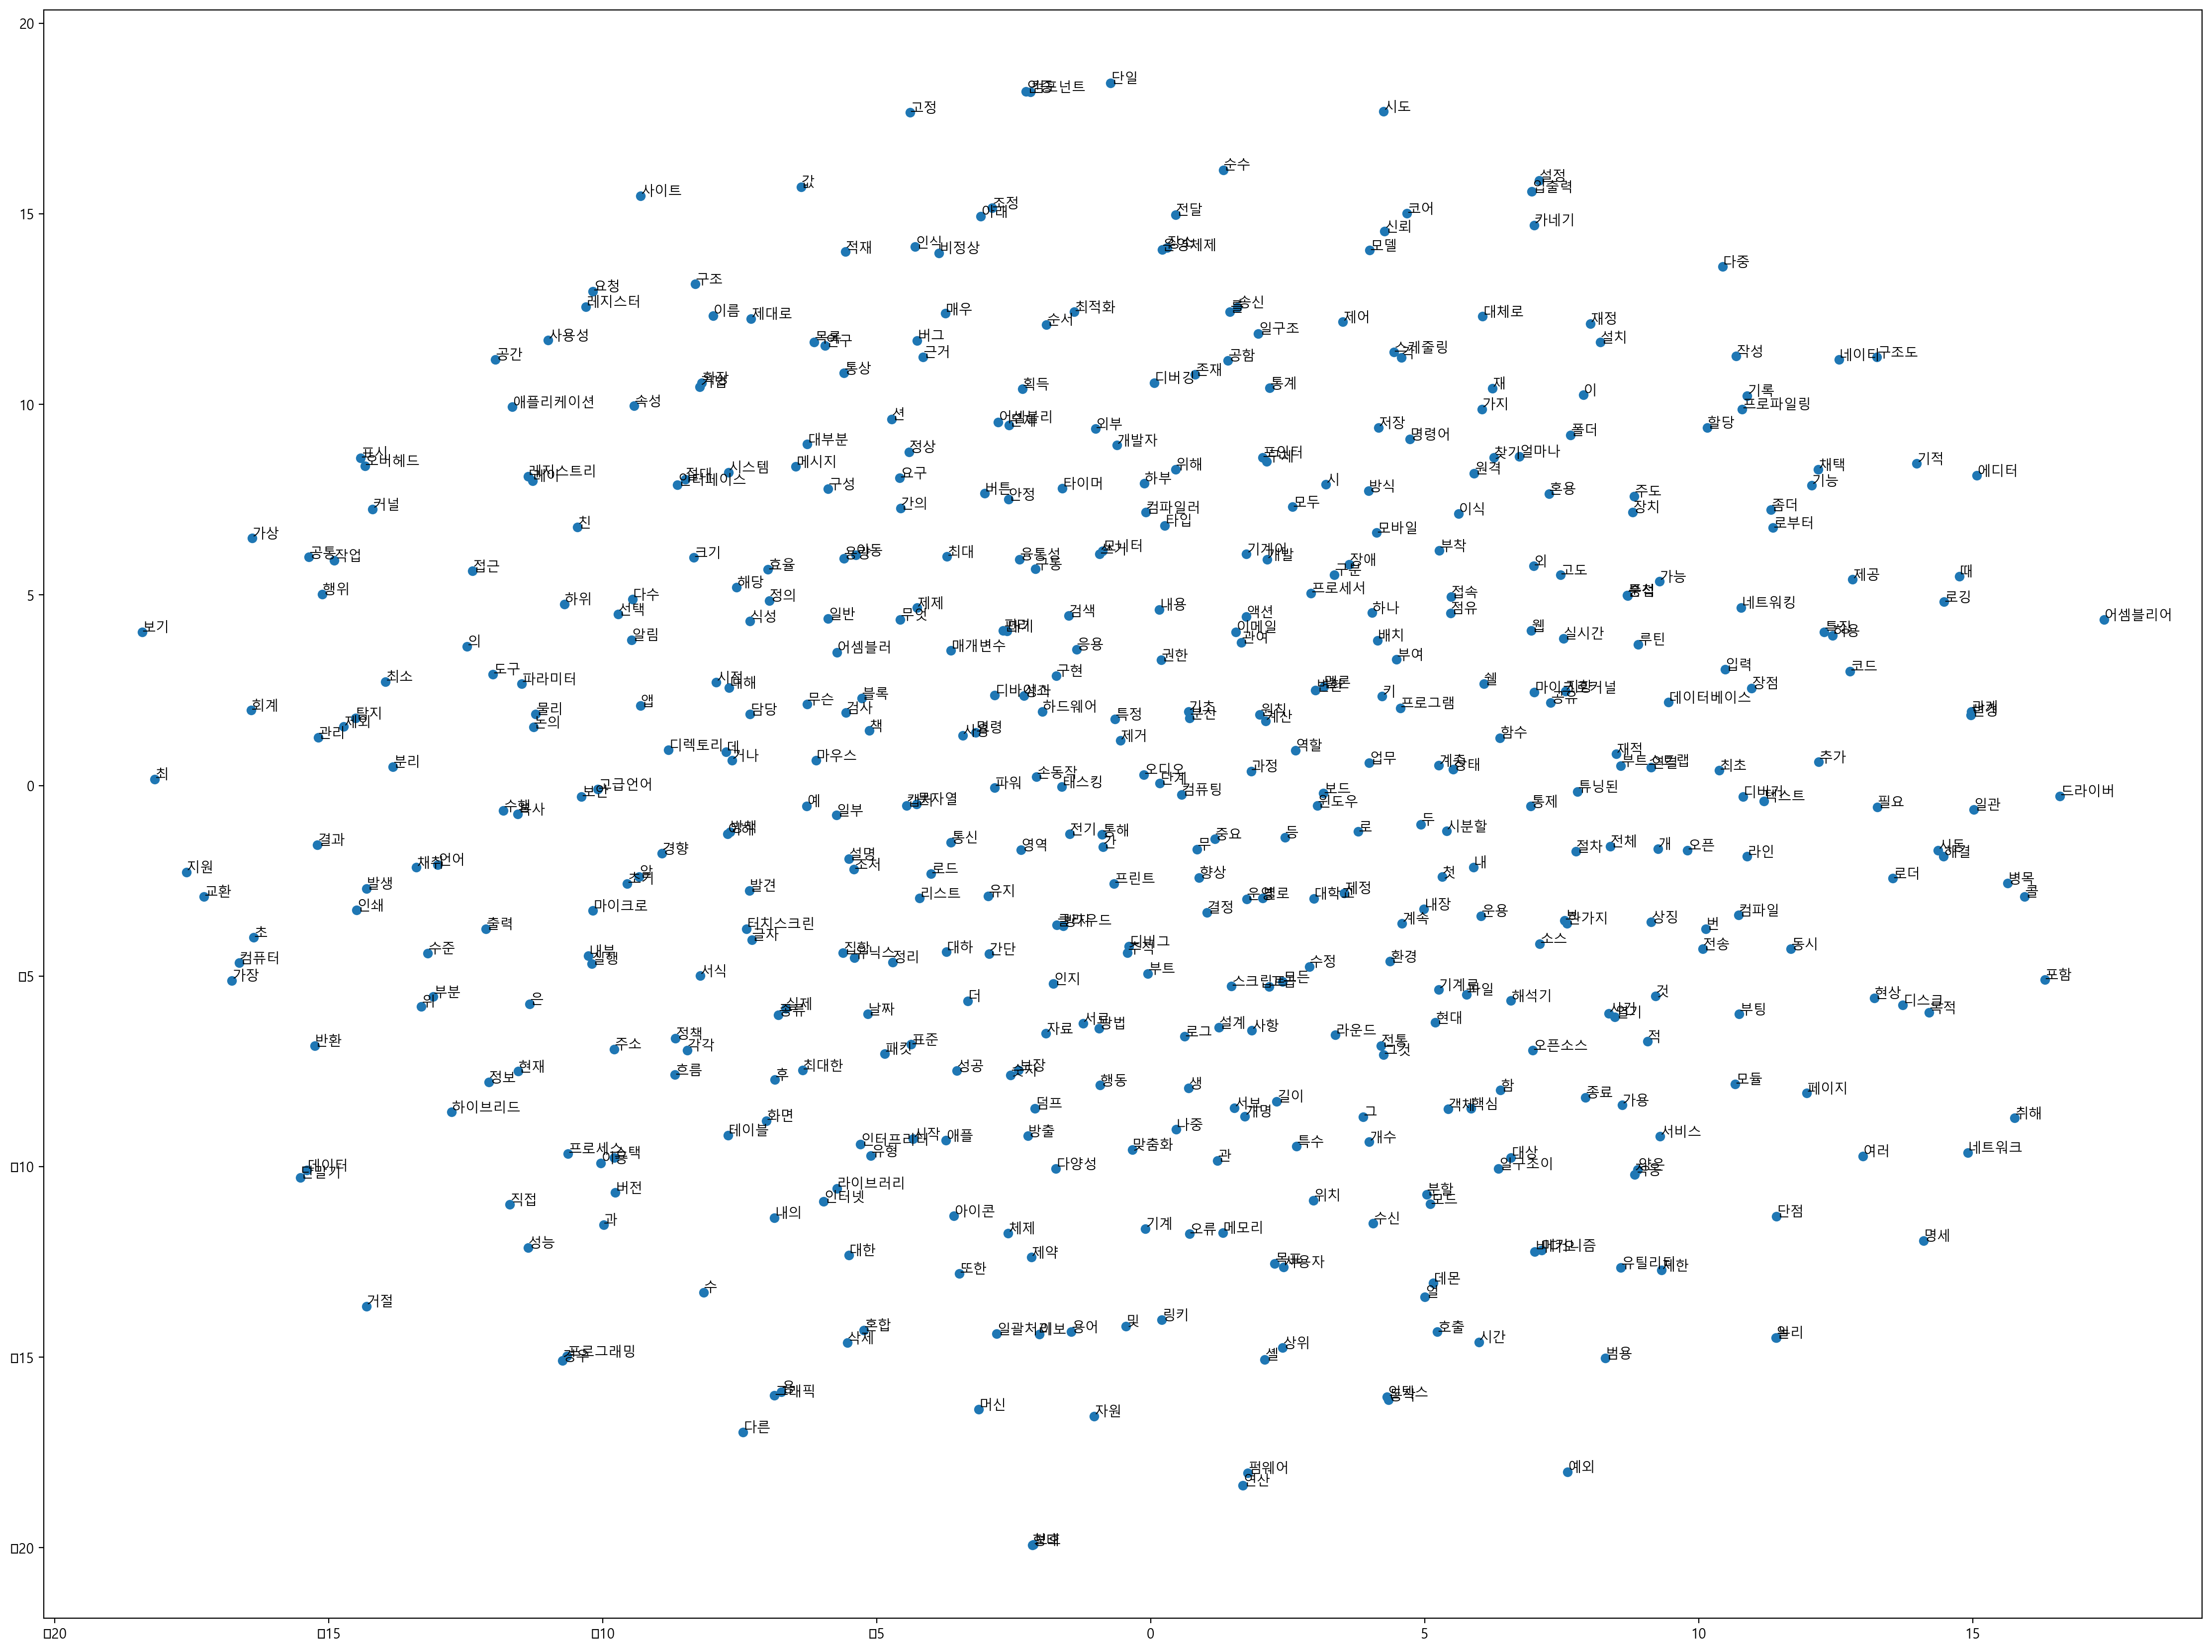

In [29]:
# https://comlini8-8.tistory.com/6
# 위의 그래프에서 모두 중간에 모여있는 것처럼 PCA는 군집의 변별력을 제대로 보존하지 못한다.
# t-SNE는 이러한 단점을 개선했다. 실제로 임베딩 결과는 t-SNE로 나타내는 경우가 많다.
from sklearn.manifold import TSNE

model2 = TSNE(learning_rate=100)
transformed = model2.fit_transform(word_vectors_list)

xs2 = transformed[:,0]
ys2 = transformed[:,1]

plt.figure(figsize=(28, 21))

plt.scatter(xs2, ys2)

for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs2[i], ys2[i]))